In [2]:
from plancraft.environments.env_real import RealPlancraft

env = RealPlancraft(
    inventory=[],
    symbolic_action_space=True,
    symbolic_observation_space=True,
    resolution=[512, 512],
    crop=True,
)
data = []

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


In [1]:
import json

with open("data/train.json", "r") as f:
    train = json.load(f)

seen_items = set()

for example in train:
    seen_items.update(example["inventory"].keys())
    seen_items.add(example["target"])

In [155]:
import random

def slot_to_bbox(slot: int):
    # crafting slot
    if slot == 0:
        # slot size: 25x25
        # top left corner: (x= 118, y=30)
        box_size = 25
        left_x = 117
        top_y = 29
    # crafting grid
    elif slot < 10:
        # slot size: 18x18
        # top left corner: (x = 28 + 18 * col, y = 16 + 18 * row)
        box_size = 18
        row = (slot - 1) // 3
        col = (slot - 1) % 3
        left_x = 27 + (box_size * col)
        top_y = 15 + (box_size * row)
    # inventory
    elif slot < 37:
        # slot size: 18x18
        # top left corner: (x= 6 + 18 * col, y=83 + 18 * row)
        box_size = 18
        row = (slot - 10) // 9
        col = (slot - 10) % 9
        left_x = 5 + (box_size * col)
        top_y = 82 + (box_size * row)
    # hotbar
    else:
        # slot size: 18x18
        # top left corner: (x= 6 + 18 * col, y=141)
        box_size = 18
        col = (slot - 37) % 9
        left_x = 5 + (box_size * col)
        top_y = 140
    return [left_x, top_y, left_x + box_size, top_y + box_size]


def sample_starting_inv():
    inventory = []
    for _ in range(random.randint(0, 35)):
        slot = random.randint(10, 44)
        inventory.append(
            {
                "type": random.choice(list(seen_items)),
                "slot": slot,
                "quantity": random.randint(1, 64),
            }
        )
    # sort by slot
    inventory = sorted(inventory, key=lambda x: x["slot"])
    return inventory

sample_starting_inv()

[{'type': 'crimson_stairs', 'slot': 35, 'quantity': 57},
 {'type': 'yellow_terracotta', 'slot': 42, 'quantity': 8}]

In [141]:
from PIL import Image
from transformers import AutoModelForVision2Seq, AutoProcessor


peft_model_id = "HuggingFaceM4/idefics2-8b-chatty"
model = AutoModelForVision2Seq.from_pretrained(
    "/nfs/public/hf/models/HuggingFaceM4/idefics2-8b-chatty",
    device_map="auto",
    local_files_only=True,
)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


In [1]:
# model.load_adapter(peft_model_id)
# model.model.vision_model

In [147]:
# from peft import LoraModel, LoraConfig

# config = LoraConfig(
#     task_type="SEQ_2_SEQ_LM",
#     r=8,
#     lora_alpha=32,
#     target_modules=["q_proj", "v_proj"],
#     lora_dropout=0.01,
# )
# lora_model = LoraModel(model, config, "default")

In [87]:
data = []
for i in range(1):
    starting_inv = sample_starting_inv()
    env.fast_reset(new_inventory=starting_inv)
    obs, _, _, _ = env.step(env.action_space.no_op())

    # clean up inventory
    clean_inv = []
    for item in starting_inv:
        if item["quantity"] > 0:
            clean_inv.append(
                {
                    "type": item["type"],
                    "index": item["slot"],
                    "quantity": item["quantity"],
                    "bbox": slot_to_bbox(item["slot"]),
                }
            )
    obs["inventory"] = clean_inv
    data.append(obs)

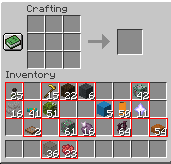

In [160]:
from PIL import Image, ImageDraw

img = Image.fromarray(data[-1]["pov"])
for item in data[-1]["inventory"]:
    draw = ImageDraw.Draw(img)
    draw.rectangle(item["bbox"], outline="red")
img.show()

In [89]:
import glob
import numpy as np
from PIL import Image, ImageSequence

observed_data = []

for f in glob.glob("/plancraft/outputs/oracle_real/train/0/*.json"):
    with open(f, "r") as file:
        inventories = json.load(file)["model_trace"]["inventory_history"]
    gif_path = str(f).replace(".json", ".gif")
    # load gif as list of images
    gif = Image.open(gif_path)
    frames = [frame.copy() for frame in ImageSequence.Iterator(gif)]
    if len(frames) != len(inventories):
        print(f)
    else:
        for frame, inv in zip(frames, inventories):
            clean_inv = []
            for item in inv:
                if item["quantity"] > 0:
                    clean_inv.append(
                        {
                            "type": item["type"],
                            "slot": item["index"],
                            "quantity": item["quantity"],
                            "bbox": slot_to_bbox(item["index"]),
                        }
                    )
            observed_data.append(
                {"inventory": clean_inv, "pov": np.array(frame.convert("RGB"))}
            )
    # assert len(frames) == len(inv), (len(frames), len(inv))

/plancraft/outputs/oracle_real/train/0/TRAIN0157.json
/plancraft/outputs/oracle_real/train/0/TRAIN0071.json


In [125]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms


class InventoryDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((224, 224)),  # Resize images to 224x224
            ]
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        pov = item["pov"]
        pov = self.transform(pov)

        inventory = item["inventory"]
        types = [i["type"] for i in inventory]
        slots = [i["slot"] for i in inventory]
        quantities = [i["quantity"] for i in inventory]
        bboxes = [i["bbox"] for i in inventory]

        return pov, types, slots, quantities, bboxes


def collate_fn(batch):
    return tuple(zip(*batch))

dataset = InventoryDataset(observed_data)
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
batch = next(iter(train_loader))

In [135]:
import torch.nn as nn
import torchvision.models as models

class InventoryModel(nn.Module):
    def __init__(self, num_types, num_slots):
        super(InventoryModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the classification layer

        # Bounding box head
        self.bbox_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 4),  # 4 coordinates for the bounding box
        )

        # Slot index prediction head
        self.slot_head = nn.Sequential(
            nn.Linear(512, 128), nn.ReLU(), nn.Linear(128, num_slots), nn.Softmax(dim=1)
        )

        # Quantity prediction head
        self.quantity_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Softmax(dim=1), 
        )

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad) // 1000000

    def forward(self, x):
        features = self.backbone(x)
        bbox = self.bbox_head(features)
        # types = self.type_head(features)
        slots = self.slot_head(features)
        quantity = self.quantity_head(features)
        return bbox, slots, quantity


# Example usage
model = InventoryModel(num_types=100, num_slots=45)  # Replace with actual numbers
model = model.cuda()
# Count number of parameters
print(f"Model has {model.count_parameters()}M parameters")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model has 11M parameters


In [136]:
pov, types, slots, quantities, bboxes = batch

In [138]:
images = torch.stack(pov)
images = images.to("cuda")

In [ ]:
# images
model.model.vision_model(images)

In [2]:
# import torch.optim as optim

# device = "cuda"

# # Define loss functions for each head
# bbox_loss_fn = nn.MSELoss()
# type_loss_fn = nn.CrossEntropyLoss()
# slot_loss_fn = nn.CrossEntropyLoss()
# quantity_loss_fn = nn.MSELoss()

# optimizer = optim.Adam(model.parameters(), lr=0.001)

# def train_model(train_loader, model, optimizer, num_epochs=10):
#     model.train()
#     for epoch in range(num_epochs):
#         for pov, types, slots, quantities, bboxes in train_loader:
#             pov = pov.to(device)
#             bboxes = bboxes.to(device)
#             types = torch.tensor(types).to(device)
#             slots = torch.tensor(slots).to(device)
#             quantities = torch.tensor(quantities).float().to(device)

#             # optimizer.zero_grad()

#             pred_bboxes, pred_types, pred_slots, pred_quantities = model(pov)

#             # loss_bbox = bbox_loss_fn(pred_bboxes, bboxes)
#             # loss_type = type_loss_fn(pred_types, types)
#             # loss_slot = slot_loss_fn(pred_slots, slots)
#             # loss_quantity = quantity_loss_fn(pred_quantities, quantities)

#             # total_loss = loss_bbox + loss_type + loss_slot + loss_quantity
#             # total_loss.backward()
#             # optimizer.step()

#         # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}")

In [3]:
# train_model(train_loader, model, optimizer, num_epochs=10)

# Get oracle O,A Dialogues

In [12]:
import json
import glob
import numpy as np
from PIL import Image, ImageSequence

with open("data/train.json", "r") as f:
    train = json.load(f)

oracle_trajectories_train = []

oracle_results = {
    "/plancraft/outputs/oracle_real/train/0/*.json": [],
    "/plancraft/outputs/oracle_real/val/0/*.json": [],
}
for path in oracle_results.keys():
    for f in glob.glob(path):
        with open(f, "r") as file:
            traj = json.load(file)

        images = []
        gif_path = str(f).replace(".json", ".gif")
        gif = Image.open(gif_path)
        for frame in ImageSequence.Iterator(gif):
            images.append(np.array(frame.convert("RGB")))
        traj["model_trace"]["images"] = images

        if (
            len(traj["model_trace"]["images"])
            == len(traj["model_trace"]["inventory_history"])
            == len(traj["model_trace"]["action_history"])
        ):
            oracle_results[path].append(traj)
        else:
            print(f)

/plancraft/outputs/oracle_real/train/0/TRAIN0341.json
/plancraft/outputs/oracle_real/train/0/TRAIN0735.json


In [26]:
from plancraft.models.react_prompts import REACT_SYSTEM_PROMPT
from collections import defaultdict


def convert_obs_to_text(objective: str, inventory: list[dict]):
    return f"TASK: {objective}\ninventory={json.dumps(inventory)}"


def convert_action_to_text(action: dict):
    # {'action_type': 'move', 'slot_from': 17, 'slot_to': 1, 'quantity': 1}
    return f"act: {action['action_type']} from slot {action['slot_from']} to slot {action['slot_to']} with quantity {action['quantity']}"


# convert action and inventory to dialogue history
def convert_trajectory_to_base_dialogue(traj: dict):
    dialogue = [{"role": "system", "content": REACT_SYSTEM_PROMPT}]
    objective = traj["model_trace"]["objective"]
    for _, action, inventory in zip(
        traj["model_trace"]["images"],
        traj["model_trace"]["action_history"],
        traj["model_trace"]["inventory_history"],
    ):
        dialogue.append(
            {
                "role": "user",
                "content": convert_obs_to_text(objective, inventory),
            }
        )
        dialogue.append(
            {
                "role": "assistant",
                "content": convert_action_to_text(action),
            }
        )
    example = {
        "messages": dialogue,
        "example_id": traj["example_id"],
    }
    return example


# convert action and inventory to dialogue history
def convert_trajectory_to_image_dialogue(traj: dict):
    dialogue = [{"role": "system", "content": [{"type": "text", "text": REACT_SYSTEM_PROMPT}]}]
    objective = traj["model_trace"]["objective"]
    images = []
    for image, action, inventory in zip(
        traj["model_trace"]["images"],
        traj["model_trace"]["action_history"],
        traj["model_trace"]["inventory_history"],
    ):
        dialogue.append(
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": objective}
                ],
            }
        )
        dialogue.append(
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": convert_action_to_text(action)}
                ]
            }
        )
        images.append(image)
    example = {
        "messages": dialogue,
        "example_id": traj["example_id"],
    }
    return example, images

import os
text_data = defaultdict(list)
mm_data = defaultdict(list)
for path,trajs in oracle_results.items():
    split = path.split("/")[-3]
    for traj in trajs:
        text_example = convert_trajectory_to_base_dialogue(traj)
        text_data[split].append(text_example)
        mm_example, example_imgs = convert_trajectory_to_image_dialogue(traj)
        mm_data[split].append(mm_example)
        # save imgs as png in format "data/oracle/{split}/{example_id}_{step}.gif"
        os.makedirs(f"data/oracle/{split}", exist_ok=True)        
        for i, img in enumerate(example_imgs):
            Image.fromarray(img).save(f"data/oracle/{split}/{traj['example_id']}_{i}.png")

    # save as jsonl file
    with open(f"data/oracle/{split}.jsonl", "w") as f:
        for example in text_data[split]:
            f.write(json.dumps(example) + "\n")
    
    with open(f"data/oracle/{split}.mm.jsonl", "w") as f:
        for example in mm_data[split]:
            f.write(json.dumps(example) + "\n")


## Finetune Llama on the oracle O,A dialogues

In [5]:
import random
import json
from datasets import Dataset


data = defaultdict(list)
for split in ["train", "val"]:
    with open(f"data/oracle/{split}.jsonl", "r") as f:
        for line in f:
            data[split].append(json.loads(line))

MAX_WINDOW_SIZE = 30
NUM_OVERSAMPLING = 3

def sample_window(example):
    # add system message
    new_messages = [example["messages"][0]]
    num_steps = len(example["messages"])-1

    start = random.randint(1, num_steps)
    if start%2 == 0:
        start = start + 1
    window_size = min(MAX_WINDOW_SIZE, start)
    new_messages = new_messages + example["messages"][start - window_size+1 : start]
    # print(f"window size: {window_size}, start: {start}, num_steps: {num_steps}")
    # new_messages = new_messages + example["messages"][start : start + window_size]
    return new_messages


def oversample_long_dialogue_dataset(examples: list[dict]):
    window_train = []
    for example in examples:
        if len(example["messages"]) > MAX_WINDOW_SIZE:
            for _ in range(NUM_OVERSAMPLING):
                window_train.append({"messages": sample_window(example)})
        else:
            window_train.append({"messages": example["messages"]})
    return window_train

train_dataset = Dataset.from_list(oversample_long_dialogue_dataset(data["train"]))
val_dataset = Dataset.from_list(oversample_long_dialogue_dataset(data["val"]))

# shuffle
train_dataset = train_dataset.shuffle(seed=42)
val_dataset = val_dataset.shuffle(seed=42)

#### Convert messages to text format 

In [12]:
from transformers import AutoTokenizer

model_name = "/nfs/public/hf/models/meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def apply_chat_template(example, tokenizer):
    messages = example["messages"]
    # We add an empty system message if there is none
    if messages[0]["role"] != "system":
        messages.insert(0, {"role": "system", "content": ""})
    example["text"] = tokenizer.apply_chat_template(messages, tokenize=False)

    return example

train_dataset = train_dataset.map(
    lambda x: apply_chat_template(x, tokenizer),
    batched=False,
    num_proc=6,
    remove_columns=["messages"],
    desc="Applying chat template to train dataset",
)
val_dataset = val_dataset.map(
    lambda x: apply_chat_template(x, tokenizer),
    batched=False,
    num_proc=6,
    remove_columns=["messages"],
    desc="Applying chat template to val dataset",
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Applying chat template to train dataset (num_proc=6): 100%|██████████| 1325/1325 [00:00<00:00, 1891.94 examples/s]
Applying chat template to val dataset (num_proc=6): 100%|██████████| 667/667 [00:00<00:00, 1329.70 examples/s]


<Axes: xlabel='len', ylabel='Count'>

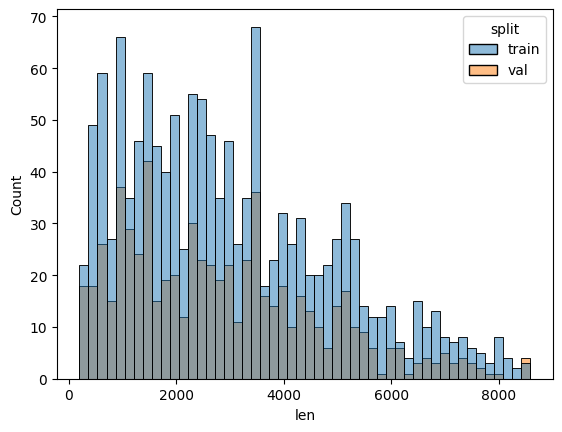

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

lengths = [{"split": "train", "len": len(tokenizer.encode(x["text"]))} for x in train_dataset]
lengths += [{"split": "val", "len": len(tokenizer.encode(x["text"]))} for x in val_dataset]
df = pd.DataFrame(lengths)
sns.histplot(df, x="len", hue="split", bins=50)

In [6]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig
from transformers import TrainingArguments

# Device map
device_map = 'auto'  # for PP and running with `python test_sft.py`
# Load the model
model_name = "/nfs/public/hf/models/meta-llama/Meta-Llama-3-8B-Instruct"
# model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer.pad_token = tokenizer.eos_token

# device_map = {"": torch.cuda.current_device()} if torch.cuda.is_available() else None
# model_kwargs = dict(
#     attn_implementation="flash_attention_2", # set this to True if your GPU supports it (Flash Attention drastically speeds up model computations)
#     torch_dtype="auto",
#     use_cache=False, # set to False as we're going to use gradient checkpointing
#     device_map=device_map,
# )

# load model
model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    torch_dtype="auto",
    trust_remote_code=True,
    local_files_only=True,
    use_cache=False,
    device_map=device_map
)

Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


In [11]:
# PEFT config
lora_alpha = 16
lora_dropout = 0.1
lora_r = 32  # 64
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["k_proj", "q_proj", "v_proj", "up_proj", "down_proj", "gate_proj"],
    modules_to_save=["embed_tokens", "input_layernorm", "post_attention_layernorm", "norm"],
)
# Args
max_seq_length = 8142
output_dir = "./outputs/training"
per_device_train_batch_size = 1  # reduced batch size to avoid OOM
gradient_accumulation_steps = 8 #2
optim = "adamw_torch"
save_steps = 10
logging_steps = 1
learning_rate = 2e-4 #2e-4
max_grad_norm = 0.3
max_steps = -1
warmup_ratio = 0.1
lr_scheduler_type = "cosine"
sft_config = SFTConfig(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    do_eval=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    max_seq_length=max_seq_length,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    gradient_checkpointing=True,  # gradient checkpointing
    report_to="wandb",
    dataset_text_field="text",
    seed=42,
    evaluation_strategy="epoch",
    num_train_epochs=3,
    save_total_limit=3,
    run_name="sft",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
model.gradient_checkpointing_enable()

In [13]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=sft_config,
)

Map: 100%|██████████| 667/667 [00:02<00:00, 224.30 examples/s]
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [14]:
train_result = trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,0.048900,0.085315
1,0.049100,0.075241
2,0.184200,0.074846


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /nfs/public/hf/models/meta-llama/Meta-Llama-3-8B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /nfs/public/hf/models/meta-llama/Meta-Llama-3-8B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils

In [14]:
# load model

from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("/plancraft/outputs/training/checkpoint-490", local_files_only=True)

Loading checkpoint shards: 100%|██████████| 4/4 [01:07<00:00, 16.94s/it]


# IDEFICS2 training

In [1]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b", do_image_splitting=False)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
from torch.utils.data import Dataset
import numpy as np
import json
from PIL import Image

class PlancraftDialogueDataset(Dataset):
    def __init__(
        self,
        dataset_dir: str = "data/oracle",
        mm=False,
        split="train",
        max_window_size=30,
    ):
        super().__init__()
        file_path = f"{dataset_dir}/{split}.jsonl"
        if mm:
            file_path = f"{dataset_dir}/{split}.mm.jsonl"

        print("Loading dialogue")
        data = []
        with open(file_path, "r") as f:
            for line in f:
                data.append(json.loads(line))

        if mm:
            print("Loading images")
            # load images
            for example in data:
                example["images"] = []
                example["message_idx_to_image_idx"] = {}
                i = 0
                for message_idx, message in enumerate(example["messages"]):
                    for content in message["content"]:
                        if content["type"] == "image":
                            img_path = (
                                f"{dataset_dir}/{split}/{example['example_id']}_{i}.png"
                            )
                            img = Image.open(img_path).convert("RGB")
                            example["images"].append(img)
                            example["message_idx_to_image_idx"][message_idx] = i
                            i += 1

        self.dataset = data
        self.max_window_size = max_window_size

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> tuple[dict, list]:
        example = self.dataset[idx]
        if len(example["messages"]) > self.max_window_size:
            # add system message
            messages = [example["messages"][0]]
            # sample window
            user_messages_idxs = list(
                range(self.max_window_size, len(example["messages"]), 2)
            )
            end = random.choice(user_messages_idxs)
            start = end - self.max_window_size + 1
            assert start != 0
            # add window
            messages = messages + example["messages"][start : end + 1]
            images = []
            if "images" in example:
                for message_idx in range(start, end):
                    if message_idx in example["message_idx_to_image_idx"]:
                        image_idx = example["message_idx_to_image_idx"][message_idx]
                        images.append(example["images"][image_idx])
        else:
            messages = example["messages"]
            images = example.get("images", [])
        return messages, images

In [3]:
from transformers import AutoProcessor, AutoTokenizer, Idefics2ForConditionalGeneration

processor = AutoProcessor.from_pretrained(
    "HuggingFaceM4/idefics2-8b", do_image_splitting=False
)
tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/Meta-Llama-3-70B-Instruct",
)
model = Idefics2ForConditionalGeneration.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    device_map="auto",
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


In [5]:
import torch
from torch.utils.data import DataLoader

TEMPLATES = {
    "idefics2": {
        "assistant": "\nAssistant:",
        "user": "\nUser:",
    },
    "llama3": {
        "assistant": "<|start_header_id|>assistant<|end_header_id|>\n\n",
        "user": "<|start_header_id|>user<|end_header_id|>\n\n",
    },
}

def track_assistant_response(
    batch,
    tokenizer,
    template_name: str = "llama3",
):
    """
    Mask that returns 1 for tokens in the assistant response and 0 otherwise.
    """
    assistant_template = TEMPLATES[template_name]["assistant"]
    user_template = TEMPLATES[template_name]["user"]
    start_seq = tokenizer.encode(
        assistant_template,
        add_special_tokens=False,
        return_tensors="pt",
    )[0]
    end_seq = tokenizer.encode(
        user_template,
        add_special_tokens=False,
        return_tensors="pt",
    )[0]
    encoded_label_ids = batch["labels"]
    mask = torch.zeros_like(encoded_label_ids)
    for seq_idx, seq in enumerate(encoded_label_ids):
        in_masked_response = False
        i = 0
        while i < len(seq):
            if i + len(start_seq) < len(seq) and torch.all(
                seq[i : i + len(start_seq)].eq(start_seq)
            ):
                in_masked_response = True
                i += len(start_seq)
                continue
            if i + len(end_seq) < len(seq) and torch.all(
                seq[i : i + len(end_seq)].eq(end_seq)
            ):
                in_masked_response = False
                i += len(end_seq)
                continue
            if in_masked_response:
                mask[seq_idx, i] = 1
            else:
                mask[seq_idx, i] = 0
            i += 1
    return mask


def get_collate_fn(
    tokenizer=None,
    processor=None,
    max_length=8142,
    only_assistant=False,
    template_name: str = "llama3",
):
    assert tokenizer or processor and not (tokenizer and processor)

    def collate_fn(batch):
        messages_batch = []
        images_batch = []
        for messages, images in batch:
            if processor:
                text = processor.apply_chat_template(
                    messages, add_generation_prompt=False, tokenize=False
                )
                images_batch.append(images)
            else:
                text = tokenizer.apply_chat_template(
                    messages, add_generation_prompt=False, tokenize=False
                )
            messages_batch.append(text)
        if processor:
            batch = processor(
                text=messages_batch,
                images=images_batch,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt",
            )
            labels = batch["input_ids"].clone()
            labels[labels == processor.tokenizer.pad_token_id] = -100
            labels[labels == model.config.image_token_id] = -100
            batch["labels"] = labels
        else:
            batch = tokenizer(
                messages_batch,
                truncation=True,
                max_length=max_length,
                return_tensors="pt",
            )
            labels = batch["input_ids"].clone()
            batch["labels"] = labels

        # add mask for assistant response
        if only_assistant:
            if processor:
                mask = track_assistant_response(
                    batch, processor.tokenizer, template_name=template_name
                )
            else:
                mask = track_assistant_response(
                    batch, tokenizer, template_name=template_name
                )
            labels[mask == 0] = -100

        return batch

    return collate_fn


dataset = PlancraftDialogueDataset(mm=True, max_window_size=30)

loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=get_collate_fn(
        processor=processor, only_assistant=True, template_name="idefics2"
    ),
)
batch = next(iter(loader))

Loading dialogue
Loading images


In [7]:
cuda_batch = {k: v.cuda() for k, v in batch.items()}

In [9]:
model(**cuda_batch)

../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [4,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [5,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_f

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [509]:
import lightning as L
from torch.utils.data import DataLoader
import numpy as np

In [ ]:
class Idefics2ModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

        self.batch_size = config.get("batch_size")

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, pixel_values, pixel_attention_mask, labels = batch

        outputs = self.model(**batch)
        loss = outputs.loss

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        input_ids, attention_mask, pixel_values, pixel_attention_mask, answers = batch

        # autoregressively generate token IDs
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            pixel_attention_mask=pixel_attention_mask,
            max_new_tokens=768,
        )
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = self.processor.batch_decode(
            generated_ids[:, input_ids.size(1) :], skip_special_tokens=True
        )

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))

        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return DataLoader(
            train_dataset,
            collate_fn=train_collate_fn,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4,
        )

    def val_dataloader(self):
        return DataLoader(
            val_dataset,
            collate_fn=eval_collate_fn,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
        )

In [508]:
print(tokenizer.batch_decode(batch["labels"][0][batch["labels"][0] != -100]))

['act', ':', ' move', ' from', ' slot', ' ', '27', ' to', ' slot', ' ', '1', ' with', ' quantity', ' ', '1', '<|eot_id|>', 'act', ':', ' move', ' from', ' slot', ' ', '10', ' to', ' slot', ' ', '2', ' with', ' quantity', ' ', '1', '<|eot_id|>', 'act', ':', ' move', ' from', ' slot', ' ', '10', ' to', ' slot', ' ', '3', ' with', ' quantity', ' ', '1', '<|eot_id|>', 'act', ':', ' move', ' from', ' slot', ' ', '0', ' to', ' slot', ' ', '11', ' with', ' quantity', ' ', '6', '<|eot_id|>']


In [ ]:
from transformers import BitsAndBytesConfig, AutoModelForVision2Seq
from peft import LoraConfig
import torch

USE_LORA = True
USE_QLORA = False

## Load model

# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning
if USE_QLORA or USE_LORA:
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
        )
    model = AutoModelForVision2Seq.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        quantization_config=bnb_config if USE_QLORA else None,
    )
else:
    # for full fine-tuning, we can speed up the model using Flash Attention
    # only available on certain devices, see https://github.com/Dao-AILab/flash-attention?tab=readme-ov-file#installation-and-features
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2",
    )

In [ ]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

# Next we can add our LoRa adapters if required.

if USE_QLORA or USE_LORA:
  lora_config = LoraConfig(
          r=32,
          lora_alpha=16,
          lora_dropout=0.1,
          target_modules=".*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$",
          use_dora=False if USE_QLORA else True,
          init_lora_weights="gaussian",
      )

  model = prepare_model_for_kbit_training(model)
  model = get_peft_model(model, lora_config)


In [ ]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[processor.tokenizer.additional_special_tokens.index("<image>")]

def train_collate_fn(examples):
    texts = []
    images = []
    for example in examples:
        images_example, question, answer = example

        content = [{"type": "image"} for _ in range(len(images_example))]
        content += [{"type": "text", "text": question}]
        # Create inputs
        messages = [
            {
                "role": "user",
                "content": content,
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": answer},
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=False)
        texts.append(prompt)
        images.append(images_example)

    batch = processor(text=texts, images=images, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")

    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == model.config.image_token_id] = -100
    batch["labels"] = labels

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]
    pixel_attention_mask = batch["pixel_attention_mask"]
    labels = batch["labels"]

    return input_ids, attention_mask, pixel_values, pixel_attention_mask, labels


def eval_collate_fn(examples):
    # we feed the prompt to the model
    images = []
    texts = []
    answers = []
    for example in examples:
        images_example, question, answer = example

        content = [{"type": "image"} for _ in range(len(images_example))]
        content += [{"type": "text", "text": question}]

        messages = [
            {
                "role": "user",
                "content": content,
            },
        ]
        text = processor.apply_chat_template(messages, add_generation_prompt=True)
        images.append(images_example)
        texts.append(text.strip())
        answers.append(answer)

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]
    pixel_attention_mask = batch["pixel_attention_mask"]

    return input_ids, attention_mask, pixel_values, pixel_attention_mask, answers

In [11]:
# processor

import lightning as L
from torch.utils.data import DataLoader
import re
from nltk import edit_distance
import numpy as np


class Idefics2ModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

        self.batch_size = config.get("batch_size")

    def training_step(self, batch, batch_idx):

        input_ids, attention_mask, pixel_values, pixel_attention_mask, labels = batch

        outputs = self.model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                pixel_values=pixel_values,
                                pixel_attention_mask=pixel_attention_mask,
                                labels=labels)
        loss = outputs.loss

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        input_ids, attention_mask, pixel_values, pixel_attention_mask, answers = batch

        # autoregressively generate token IDs
        generated_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                       pixel_values=pixel_values, pixel_attention_mask=pixel_attention_mask,
                                       max_new_tokens=MAX_LENGTH)
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))

        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=self.batch_size, shuffle=False, num_workers=4)


In [ ]:
config = {"max_epochs": 10,
          # "val_check_interval": 0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 1e-4,
          "batch_size": 2,
          "precision": "16-mixed", # we'll use mixed precision
          # "seed":2022, # can be used for reproducibility
          "warmup_steps": 50,
          "result_path": "./result",
          "verbose": True,
}

model_module = Idefics2ModelPLModule(config, processor, model)

In [ ]:
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub(FINETUNED_REPO_ID,
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub(FINETUNED_REPO_ID,
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub(FINETUNED_REPO_ID,
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

In [ ]:
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project=WANDB_PROJECT, name=WANDB_NAME)

trainer = L.Trainer(
        accelerator="gpu",
        devices=[0],
        max_epochs=config.get("max_epochs"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        precision=config.get("precision"),
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[PushToHubCallback(), early_stop_callback],
)

trainer.fit(model_module)